In [1]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('wine').getOrCreate()

In [2]:
from pyspark.sql.types import (StructField,StringType,IntegerType,StructType,DoubleType)
import numpy as np

redData = spark.read.format("csv").option("header", "true").load("./data/winequality-red.csv")
col=redData.columns

data_schema = [StructField(col[0],DoubleType(),True),
              StructField(col[1],DoubleType(),True),
              StructField(col[2],DoubleType(),True),
              StructField(col[3],DoubleType(),True),
              StructField(col[4],DoubleType(),True),
              StructField(col[5],DoubleType(),True),
              StructField(col[6],DoubleType(),True),
              StructField(col[7],DoubleType(),True),
              StructField(col[8],DoubleType(),True),
              StructField(col[9],DoubleType(),True),
              StructField(col[10],DoubleType(),True),
              StructField(col[11],IntegerType(),True)]
final_struct = StructType(fields=data_schema)

redData = spark.read.format("csv").option("header", "true").load("./data/winequality-red.csv", schema=final_struct)
whiteData = spark.read.format("csv").option("header", "true").load("./data/winequality-white.csv", schema=final_struct)


from pyspark.sql.functions import lit

redData=redData.withColumn("color", lit('red'))
whiteData=whiteData.withColumn("color", lit('white'))

combinedData = redData.union(whiteData)
col=combinedData.columns

In [3]:
# Randomize Data


First Done for Quality

In [4]:
# A few things we need to do before Spark can accept the data!
# It needs to be in the form of two columns: "label" and "features".

# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

qualityModelsDf = alcoholContentModelDf = combinedData.select(col[0:12])
colorModelDf = combinedData.select('fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol',
           'color')

# Combine all features into one vector named features.
assembler = VectorAssembler(
inputCols=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
              outputCol="features")

# Let's transform the data. 
outputQuality = assembler.transform(qualityModelsDf)

In [5]:
# Let's import the string indexer (similar to the logistic regression exercises).
from pyspark.ml.feature import StringIndexer, OneHotEncoder

indexerQuality = StringIndexer(inputCol=col[11], outputCol="QualityIndex")
#quality_encoder = OneHotEncoder(inputCol='QualityIndex',outputCol='QualityVec')

output_fixed_quality = indexerQuality.fit(outputQuality).transform(outputQuality)

# Let's select the two columns we want. Features (which contains vectors), and the predictor.
final_data_quality = output_fixed_quality.select("features",'QualityIndex')

# Split the training and testing set.
train_data_quality,test_data_quality = final_data_quality.randomSplit([0.8,0.2])

Models For Quality: Decision Tree and Random Forest

In [6]:
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline


dtc = DecisionTreeClassifier(labelCol='QualityIndex',featuresCol='features', seed=123456789)
rfc = RandomForestClassifier(labelCol='QualityIndex',featuresCol='features', seed=123456789)

In [7]:
dtc_model = dtc.fit(train_data_quality)
rfc_model = rfc.fit(train_data_quality)

In [8]:
dtc_predictions = dtc_model.transform(test_data_quality)
rfc_predictions = rfc_model.transform(test_data_quality)

In [9]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
acc_evaluator = MulticlassClassificationEvaluator(labelCol="QualityIndex", predictionCol="prediction", metricName="accuracy")

dtc_acc = acc_evaluator.evaluate(dtc_predictions)
rfc_acc = acc_evaluator.evaluate(rfc_predictions)

print('-'*40)
print('A single decision tree has an accuracy of: {0:2.2f}%'.format(dtc_acc*100))
print('-'*40)
print('A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfc_acc*100))

----------------------------------------
A single decision tree has an accuracy of: 52.28%
----------------------------------------
A random forest ensemble has an accuracy of: 54.25%


Text(0,0.5,'Importance')

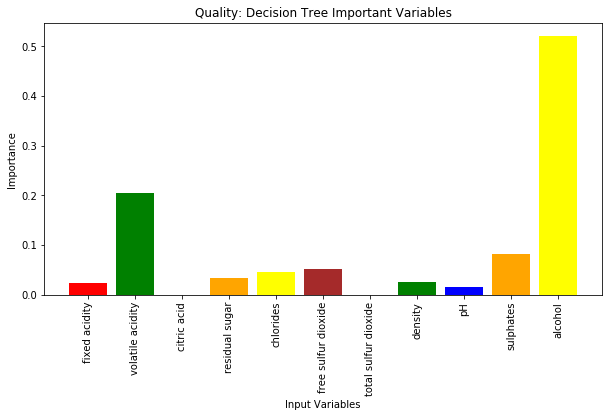

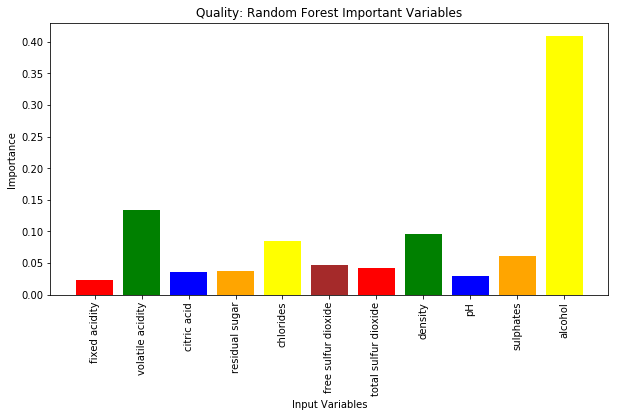

In [23]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]

fig1, ax1 = plt.subplots()
ax1.set_title("Quality: Decision Tree Important Variables")
plt.bar(x=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
         height=dtc_model.featureImportances,
       color=["red","green","blue","orange","yellow","brown"])
plt.xticks(rotation='vertical')
plt.xlabel("Input Variables")
plt.ylabel("Importance")

fig1, ax1 = plt.subplots()
ax1.set_title("Quality: Random Forest Important Variables")
plt.bar(x=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
         height=rfc_model.featureImportances,
       color=["red","green","blue","orange","yellow","brown"])
plt.xticks(rotation='vertical')
plt.xlabel("Input Variables")
plt.ylabel("Importance")

Then Done for Alcohol

In [11]:
# Combine all features into one vector named features.
assemblerAlc = VectorAssembler(
inputCols=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'quality'],
              outputCol="featuresAlc")

# Let's transform the data. 
outputAlcohol = assemblerAlc.transform(alcoholContentModelDf)

In [12]:
final_data_alcohol = outputAlcohol.select("featuresAlc",'alcohol')

# Split the training and testing set.
train_data_alcohol,test_data_alcohol = final_data_alcohol.randomSplit([0.8,0.2])

Models for Alcohol

In [13]:
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator

dt = DecisionTreeRegressor(featuresCol="featuresAlc",labelCol="alcohol", seed=123456789)
dtModel = dt.fit(train_data_alcohol)
dtPredictions = dtModel.transform(test_data_alcohol)

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol="featuresAlc",labelCol="alcohol", seed=123456789)
rfModel = rf.fit(train_data_alcohol)
rfPredictions = rfModel.transform(test_data_alcohol)

In [14]:
evaluator = RegressionEvaluator(labelCol="alcohol", predictionCol="prediction", metricName="rmse")
rmseDt = evaluator.evaluate(dtPredictions)
rmseRf = evaluator.evaluate(rfPredictions)
print("Decision Tree: Root Mean Squared Error (RMSE) on test data = %g" % rmseDt)
print("Random Forest: Root Mean Squared Error (RMSE) on test data = %g" % rmseRf)

evaluatorR2 = RegressionEvaluator(labelCol="alcohol", predictionCol="prediction", metricName="r2")
r2Dt = evaluatorR2.evaluate(dtPredictions)
r2Rf = evaluatorR2.evaluate(rfPredictions)
print("Decision Tree: R2 on test data = %g" % r2Dt)
print("Random Forest: R2 on test data = %g" % r2Rf)

Decision Tree: Root Mean Squared Error (RMSE) on test data = 0.683724
Random Forest: Root Mean Squared Error (RMSE) on test data = 0.678637
Decision Tree: R2 on test data = 0.673032
Random Forest: R2 on test data = 0.677878


Text(0,0.5,'Importance')

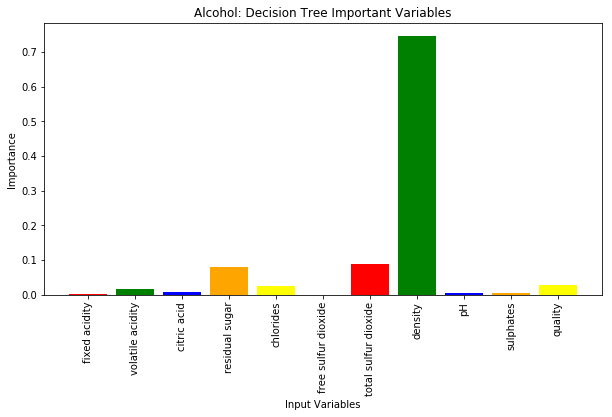

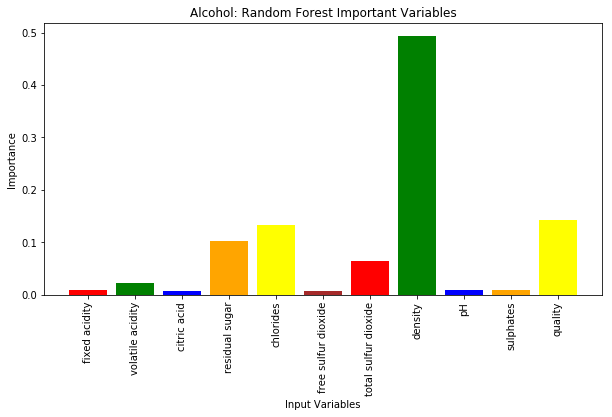

In [15]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]

fig1, ax1 = plt.subplots()
ax1.set_title("Alcohol: Decision Tree Important Variables")
plt.bar(x=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'quality'],
         height=dtModel.featureImportances,
       color=["red","green","blue","orange","yellow","brown"])
plt.xticks(rotation='vertical')
plt.xlabel("Input Variables")
plt.ylabel("Importance")

fig1, ax1 = plt.subplots()
ax1.set_title("Alcohol: Random Forest Important Variables")
plt.bar(x=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'quality'],
         height=rfModel.featureImportances,
       color=["red","green","blue","orange","yellow","brown"])
plt.xticks(rotation='vertical')
plt.xlabel("Input Variables")
plt.ylabel("Importance")


Then Done for Color

In [16]:
assembler = VectorAssembler(
inputCols=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
              outputCol="featuresCol")

# Let's transform the data. 
outputColor = assembler.transform(colorModelDf)

In [17]:
# Let's import the string indexer (similar to the logistic regression exercises).
from pyspark.ml.feature import StringIndexer

indexerColor = StringIndexer(inputCol=col[12], outputCol="ColorIndex")
output_fixed_color = indexerColor.fit(outputColor).transform(outputColor)

# Let's select the two columns we want. Features (which contains vectors), and the predictor.
final_data_color = output_fixed_color.select("featuresCol",'ColorIndex')

# Split the training and testing set.
train_data_color,test_data_color = final_data_color.randomSplit([0.8,0.2])

Models for Color

In [18]:
# Let's import the relevant classifiers. 
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline

# Use defaults to make the comparison "fair". This simplifies the comparison process.

dtcC = DecisionTreeClassifier(labelCol='ColorIndex',featuresCol='featuresCol', seed=123456789)
rfcC = RandomForestClassifier(labelCol='ColorIndex',featuresCol='featuresCol', seed=123456789)

In [19]:
# Train the models (it's three models, so it might take some time).
dtcC_model = dtcC.fit(train_data_color)
rfcC_model = rfcC.fit(train_data_color)

# Current GB only works with binary classification

In [20]:
dtcC_predictions = dtcC_model.transform(test_data_color)
rfcC_predictions = rfcC_model.transform(test_data_color)

In [21]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
my_binary_eval = BinaryClassificationEvaluator(labelCol = 'ColorIndex')

dtcC_acc = my_binary_eval.evaluate(dtcC_predictions)
rfcC_acc = my_binary_eval.evaluate(rfcC_predictions)

print('-'*40)
print('Color: A single decision tree has an accuracy of: {0:2.2f}%'.format(dtcC_acc*100))
print('-'*40)
print('Color: A random forest ensemble has an accuracy of: {0:2.2f}%'.format(rfcC_acc*100))

----------------------------------------
Color: A single decision tree has an accuracy of: 94.67%
----------------------------------------
Color: A random forest ensemble has an accuracy of: 99.46%


Text(0,0.5,'Importance')

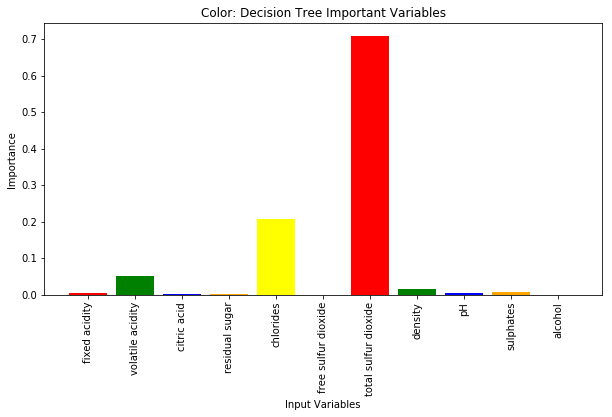

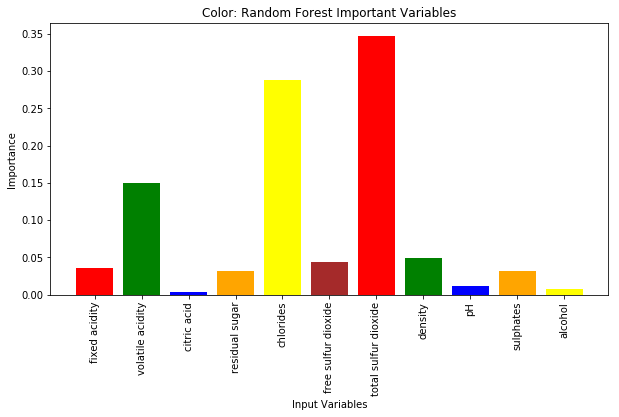

In [22]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = [10, 5]

fig1, ax1 = plt.subplots()
ax1.set_title("Color: Decision Tree Important Variables")
plt.bar(x=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
         height=dtcC_model.featureImportances,
       color=["red","green","blue","orange","yellow","brown"])
plt.xticks(rotation='vertical')
plt.xlabel("Input Variables")
plt.ylabel("Importance")

fig1, ax1 = plt.subplots()
ax1.set_title("Color: Random Forest Important Variables")
plt.bar(x=['fixed acidity', 
           'volatile acidity', 
           'citric acid',
           'residual sugar', 
           'chlorides', 
           'free sulfur dioxide',
           'total sulfur dioxide', 
           'density', 
           'pH', 
           'sulphates', 
           'alcohol'],
         height=rfcC_model.featureImportances,
       color=["red","green","blue","orange","yellow","brown"])
plt.xticks(rotation='vertical')
plt.xlabel("Input Variables")
plt.ylabel("Importance")